35 vlc eRMS = 0.09584195578625726  pRMS =  0.24173026666984215
full SVD eRMS = 0.06633197119054408  pRMS = 0.7702064915068566
BAB parameter RMS =  0.24172706350503917


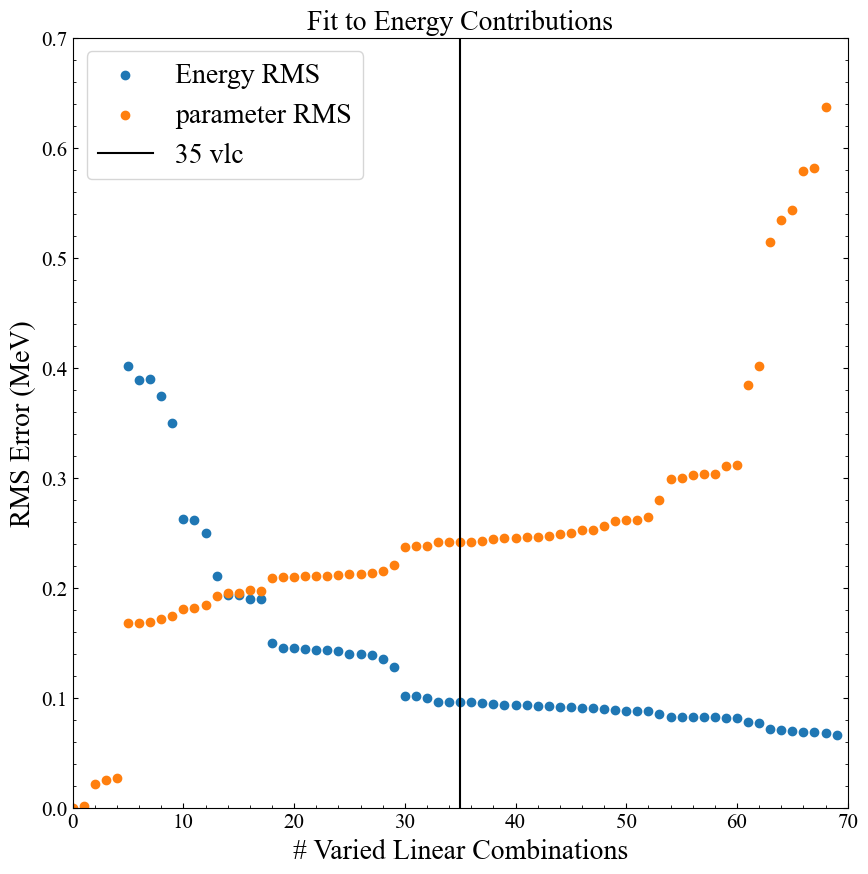

In [17]:
# This version of the SVD fits using states expressed as excitations relative to a nuclear ground state
# RMS error for this fit looks to be a match with e35 produced by BAB
import csv
import math
import scipy.linalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy.linalg import inv

# Read output-energy file as fixed-width file (fwf) into dataframe object, columns aren't labeled with a header
energyDF = pd.read_csv('xfit.dat', header=None, delim_whitespace=True).to_numpy()

# extract the SPEs and TBME's for the background (n50em) interaction
backgroundHam = energyDF[0,5:75]      # First 5 terms are not Hamiltonian parameters and can be dropped

# do the same for the fitted interaction from BAB
fittedHam = energyDF[1,5:75]

# extract experimental energies and experimental errors from dataframe
exp = energyDF[2:,1]
expAbs = energyDF[2:,2]
error = energyDF[2:,3]
#print(exp)

# extract matrix of beta coefficients for calculating absolute energies of each state
betasAbs = energyDF[2:,5:]

# extract a matrix of the beta coefficients in each energy contribution for the Hamiltonian in terms of excited states
betas = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    for j in range(len(backgroundHam)):
        if exp[i] <= 0:
            betas[i,j] = energyDF[i+2,j+5]
            gsContributions = betas[i,:]
        else:
            betas[i,j] = energyDF[i+2,j+5] - gsContributions[j]

# Finally we construct our design matrix (G), initial parameter vector (pInit), and data vector (e) for fitting
e = np.empty(len(backgroundHam))
G = np.empty((len(backgroundHam),len(backgroundHam)))
for i in range(len(backgroundHam)):           # Contructing data vector (e)
    eTot = 0
    for k in range(len(exp)):
        eTot += (exp[k]*betas[k,i])/(error[k]**2)
    e[i] = eTot
for i in range(len(backgroundHam)):           # Constructing design matrix (G)
    for j in range(len(backgroundHam)):
        gTot = 0
        for k in range(len(exp)):
            gTot += (betas[k,i]*betas[k,j])/(error[k]**2)
        G[i,j] = gTot

# Here we perform an SVD of our design matrix and invert the singular values (in S)
# to create linear combinations of our parameters in p for our successive fits, iterating over the singular values
U, Svec, Ut = np.linalg.svd(G)
# Now we apply our minimization (e = Gp) by using our SVD matrices U,S, and Ut to rotate
# e and p into new vectors c and y, respectively
c = np.dot(Ut,e)
y = np.dot(Ut,backgroundHam)

# This is where we iteratively vary the linear combinations of parameters by selecting the increasing values in Sinv
# at the end we will apply fitted weights p to our initial parameters to calculate their RMS and energy RMS
eRMS = np.empty(len(Svec)+1)                  # The +1 is to include the unfitted case where we vary 0 linear combinations
pRMS = np.empty(len(Svec)+1)
fitEnergies = np.empty(len(exp))              # Array for storing fitted energies resulting from the chosen #VLC fit
numVLC = 35                                   # Number of VLC to choose for the output Hamiltonian
for i in range(len(backgroundHam)+1):
    yfit = np.zeros(len(backgroundHam))
    fitParameters = np.empty(len(backgroundHam))               # Array for storing fitted parameters in this iteration
    eResidual = np.empty(0)                             # Array for storing residuals for RMS calculation
    for j in range(len(backgroundHam)):
        if j < i:                             # Modify our linear combinations in y = U^Tp by our data in c = U^Te
            yfit[j] = c[j]/Svec[j]
        elif j >= i:                           # Keep the original linear combinations y = U^Tp from starting Hamiltonian
            yfit[j] = y[j]
    fitParameters = np.dot(U,yfit)                      # Rotate back to our fitted p vector through p = Uy
    for j in range(len(exp)):
        eFitTot = 0
        if i==numVLC:
            for k in range(len(backgroundHam)):
                eFitTot += fitParameters[k]*betasAbs[j,k]
            fitEnergies[j] = eFitTot
        eFitTot = 0
        for k in range(len(backgroundHam)):
            eFitTot += fitParameters[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
        if error[j] <= 1.0:
            eResidual = np.append(eResidual, exp[j]-eFitTot)
    if i == numVLC:
        outputHam = fitParameters
    pResidual = backgroundHam[4:] - fitParameters[4:]
    eRMS[i] = scipy.linalg.norm(eResidual)/math.sqrt(len(eResidual))
    pRMS[i] = scipy.linalg.norm(pResidual)/math.sqrt(len(pResidual))
    
print('35 vlc eRMS =', eRMS[34], ' pRMS = ', pRMS[34])
print('full SVD eRMS =', eRMS[69], ' pRMS =', pRMS[69])
print('BAB parameter RMS = ', scipy.linalg.norm(backgroundHam[4:]-fittedHam[4:])/math.sqrt(len(pResidual)))
x = [i for i in range(len(eRMS))]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter(x, eRMS, label='Energy RMS')
plt.scatter(x, pRMS, label='parameter RMS')
plt.axvline(x = 35, color = 'k', label = '35 vlc')
plt.xlabel('# Varied Linear Combinations')
plt.ylabel('RMS Error (MeV)')
plt.title('Fit to Energy Contributions',fontsize=20)
plt.axis([0,70,0.0,0.7])
plt.minorticks_on()
plt.tick_params(which="both", direction="in", right=True)
plt.legend(loc=2,fontsize=20)
plt.show()

In [140]:
vlcCount = np.zeros([len(backgroundHam)+1])
print(vlcCount)
for i in range(len(backgroundHam)+1):
    vlcCount[i] = i
print(vlcCount)
rmsOutput = np.array([vlcCount, eRMS, pRMS])
with open("rms.dat", "w") as f:
    f.write("RMS Error \n")
    f.write("VLC    Energy     Params \n")
    np.savetxt(f, rmsOutput.T, delimiter=' ', fmt=('%-2d', '%10.4f', '%10.4f'))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69.]


In [62]:
# Fit using a handwritten least-squares solution to the minimization problem
Ginv = inv(G)
pfinal = np.dot(Ginv,e)
newHam = np.empty(len(backgroundHam))
pRes = pfinal-backgroundHam
eRes = np.empty(0)
for j in range(len(exp)):
        if error[j] <= 1.0:
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += pfinal[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            eRes = np.append(eRes, eFitTot - exp[j])
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))


least squares energy RMS = 0.06633197118292827
least squares parameter RMS = 0.7476037608406919


In [19]:
outputs1 = np.array([exp, error, energyDF[2:,4], fitEnergies, energyDF[2:,4]-fitEnergies])
outputs2 = np.array([fittedHam, outputHam, outputHam-fittedHam])

with open("outputsBetas.dat","w") as f:
    f.write("Energy outputs   (0.096 MeV RMS for JP fit): \n")
    f.write("       exp      error        BAB         JP       Diff \n")
    np.savetxt(f, outputs1.T, delimiter=' ', fmt='%10.4f')
    f.write("Parameter outputs (0.235 MeV RMS for 35 VLC fit): \n")
    f.write("       BAB         JP       Diff \n")
    np.savetxt(f, outputs2.T, delimiter=' ', fmt='%10.4f')



In [63]:
# Least squares solution using numpy linalg as a check that my least squares solution agrees
newExp = np.empty(len(exp))
M = np.empty([len(exp),len(backgroundHam)])
for i in range(len(exp)):
    newExp[i] = exp[i]/error[i]
    for j in range(len(backgroundHam)):
        M[i,j] = betas[i,j]/error[i]
lstSq = np.linalg.lstsq(M, newExp, rcond=None)
lsHam = lstSq[0]
#print(lstSq[0])                    # This is the set of weights which minimizes least squares for the energy contributions
lsEnergy = np.empty(len(exp))
eRes = np.empty(0)
for j in range(len(exp)):
        if error[j] <= 1.0:
            eFitTot = 0
            for k in range(len(backgroundHam)):
                eFitTot += lsHam[k]*betas[j,k]                # Modify our initial energy contributions to state j by new weights
            eRes = np.append(eRes, exp[j]-eFitTot)
print('least squares energy RMS =', scipy.linalg.norm(eRes)/math.sqrt(len(eRes)))
pRes = lsHam-backgroundHam
print('least squares parameter RMS =', scipy.linalg.norm(pRes)/math.sqrt(len(pRes)))

least squares energy RMS = 0.06633197119046383
least squares parameter RMS = 0.7476037609754748


In [13]:
sum1 = 0
for i in range(4,len(backgroundHam)):
    sum1 += (backgroundHam[i]-outputHam[i])**2
print(math.sqrt(sum1/(len(backgroundHam)-4)))
babHam = energyDF[1,5:]

sum2 = 0
for i in range(4,len(babHam)):
    sum2 += (backgroundHam[i]-babHam[i])**2
print(math.sqrt(sum2/(len(backgroundHam)-4)))

0.2417310754465279
0.24172706350503914
